In [88]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np

# =========================
# 1. Load & Utility
# =========================
def load_adbench_data(dataset_path):
    """
    Giả sử file .npz có 'X' và 'y'
    X: (N, d), y: (N,)
    """
    data = np.load(dataset_path)
    X = data['X']
    y = data['y']
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

def evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch).squeeze()  # (B,)
            all_preds.append(y_pred.cpu())
            all_labels.append(y_batch.cpu())

    preds = torch.cat(all_preds).numpy()      # (N_test,)
    labels = torch.cat(all_labels).numpy()    # (N_test,)

    # Chuyển sang nhãn nhị phân
    binary_preds = (preds > threshold).astype(int)

    report = classification_report(labels, binary_preds, target_names=['Class 0', 'Class 1'])
    print(report)

    if len(set(labels)) > 1:
        aucroc = roc_auc_score(labels, preds)
        print(f"AUC-ROC: {aucroc:.4f}")
    else:
        aucroc = None
        print("AUC-ROC: Undefined (only one class present in labels)")
    return report, aucroc

# =========================
# 2. Beta-CVAE
# =========================
class BetaCVAE(nn.Module):
    """
    Beta-CVAE cho bài toán nhị phân:
      - Encoder nhận (x, y)
      - Decoder nhận (z, y)
      - Thêm hệ số beta > 1 cho KL-divergence để khuyến khích latent space 'trải rộng'.
    """
    def __init__(self, input_dim, hidden_dim=128, latent_dim=64, beta=4.0):
        super(BetaCVAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.beta = beta  # hệ số "phóng đại" KL

        # Encoder
        self.fc1 = nn.Linear(input_dim + 1, hidden_dim)   # concat y -> +1
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder
        self.fc3 = nn.Linear(latent_dim + 1, hidden_dim)  # concat y -> +1
        self.fc4 = nn.Linear(hidden_dim, input_dim)

    def encode(self, x, y):
        xy = torch.cat([x, y], dim=1)  # (B, input_dim+1)
        h = F.relu(self.fc1(xy))
        mean = self.fc2_mean(h)
        logvar = self.fc2_logvar(h)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mean + eps * std

    def decode(self, z, y):
        zy = torch.cat([z, y], dim=1)  # (B, latent_dim+1)
        h = F.relu(self.fc3(zy))
        x_recon = self.fc4(h)
        return x_recon

    def forward(self, x, y):
        mean, logvar = self.encode(x, y)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z, y)
        return x_recon, mean, logvar

def beta_cvae_loss_fn(x, x_recon, mean, logvar, beta=4.0):
    """
    Reconstruction (MSE) + beta * KL-div
    """
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_loss    = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss

def train_beta_cvae(model, data_loader, optimizer, device):
    model.train()
    total_loss = 0
    for x_batch, y_batch in data_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).unsqueeze(1)  # (B,1)
        
        x_recon, mean, logvar = model(x_batch, y_batch)
        loss = beta_cvae_loss_fn(x_batch, x_recon, mean, logvar, beta=model.beta)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


# =========================
# 3. Transformer Detector
# =========================
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        L = x.size(1)
        return x + self.pe[:, :L, :].to(x.device)

class TransformerDetector(nn.Module):
    def __init__(self, input_size, d_model=128, nhead=8, num_layers=2, dim_feedforward=256, dropout=0.1):
        super(TransformerDetector, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dim_feedforward=dim_feedforward, 
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Sequential(
            nn.Linear(d_model, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        return self.fc(x).squeeze(1)

def train_detector(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_pred = model(X_batch)  # (B,)
        loss = criterion(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)





In [89]:
# =========================
# 4. MAIN DEMO
# =========================
if __name__ == "__main__":
    # Ví dụ đường dẫn
    dataset_path = r"D:\Study\Code\SwiftHydra\Classical\12_fault.npz"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 4.1: Load Data
    X_all, y_all = load_adbench_data(dataset_path)
    input_dim = X_all.shape[1]

    # Chia train/test
    X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
        X_all.numpy(), y_all.numpy(), test_size=0.2, random_state=42, stratify=y_all
    )
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.float32)
    X_test  = torch.tensor(X_test_np,  dtype=torch.float32)
    y_test  = torch.tensor(y_test_np,  dtype=torch.float32)

    # DataLoader cho Beta-CVAE
    train_dataset = TensorDataset(X_train, y_train)
    train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)

    # 4.2: Khởi tạo Beta-CVAE
    # Tăng beta (vd=4.0) để nhấn mạnh KL -> latent space "trải rộng" hơn
    beta_cvae = BetaCVAE(input_dim=input_dim, hidden_dim=128, latent_dim=32, beta=1.0).to(device)
    optimizer_cvae = Adam(beta_cvae.parameters(), lr=1e-3)
    
    

    

In [90]:
# Train Beta-CVAE
num_epochs_cvae = 450
for epoch in range(num_epochs_cvae):
    loss_cvae = train_beta_cvae(beta_cvae, train_loader, optimizer_cvae, device)
    if (epoch + 1) % 2 == 0:
        print(f"[Beta-CVAE] Epoch {epoch+1}/{num_epochs_cvae}, loss={loss_cvae:.2f}")


    

[Beta-CVAE] Epoch 2/450, loss=1307.45
[Beta-CVAE] Epoch 4/450, loss=1084.93
[Beta-CVAE] Epoch 6/450, loss=1015.08
[Beta-CVAE] Epoch 8/450, loss=968.82
[Beta-CVAE] Epoch 10/450, loss=945.15
[Beta-CVAE] Epoch 12/450, loss=938.16
[Beta-CVAE] Epoch 14/450, loss=922.84
[Beta-CVAE] Epoch 16/450, loss=898.02
[Beta-CVAE] Epoch 18/450, loss=879.40
[Beta-CVAE] Epoch 20/450, loss=873.52
[Beta-CVAE] Epoch 22/450, loss=855.20
[Beta-CVAE] Epoch 24/450, loss=850.15
[Beta-CVAE] Epoch 26/450, loss=837.22
[Beta-CVAE] Epoch 28/450, loss=817.47
[Beta-CVAE] Epoch 30/450, loss=810.31
[Beta-CVAE] Epoch 32/450, loss=789.36
[Beta-CVAE] Epoch 34/450, loss=779.92
[Beta-CVAE] Epoch 36/450, loss=784.84
[Beta-CVAE] Epoch 38/450, loss=778.09
[Beta-CVAE] Epoch 40/450, loss=768.61
[Beta-CVAE] Epoch 42/450, loss=762.93
[Beta-CVAE] Epoch 44/450, loss=755.03
[Beta-CVAE] Epoch 46/450, loss=748.75
[Beta-CVAE] Epoch 48/450, loss=739.82
[Beta-CVAE] Epoch 50/450, loss=741.73
[Beta-CVAE] Epoch 52/450, loss=738.91
[Beta-CVAE] E

In [96]:
# 4.3: Sinh dữ liệu - maximize diversity
"""
Thay vì z ~ Normal(0,1), ta thử z ~ Uniform([-2,2]) => 
tăng coverage, khuyến khích dữ liệu sinh ra đa dạng hơn
"""
beta_cvae.eval()

minority_mask = (y_train == 1)
X_minority = X_train[minority_mask]
majority_mask = (y_train == 0)
X_majority = X_train[majority_mask]

num_generate = len(X_majority) - len(X_minority)  # Hoặc tuỳ ý # số lượng sample sinh ra
with torch.no_grad():
    # Tạo z uniform trong [-2,2]
    z_uniform = (torch.rand(num_generate, beta_cvae.latent_dim) * 4.0) - 2.0
    z_uniform = z_uniform.to(device)

    # Gán y=1 => oversample minority
    # hoặc y=0.7 => “lai”
    # Ở đây ta ví dụ oversample minority
    y_synthetic_c = torch.full((num_generate, 1), 0.9, device=device)

    # Decode
    X_synthetic = beta_cvae.decode(z_uniform, y_synthetic_c)
    X_synthetic = X_synthetic.cpu()

# Tạo label = 1 cho samples synthetic
y_synthetic_labels = torch.ones(num_generate)

# Ghép lại
X_train_final = torch.cat([X_train, X_synthetic], dim=0)
y_train_final = torch.cat([y_train, y_synthetic_labels], dim=0)


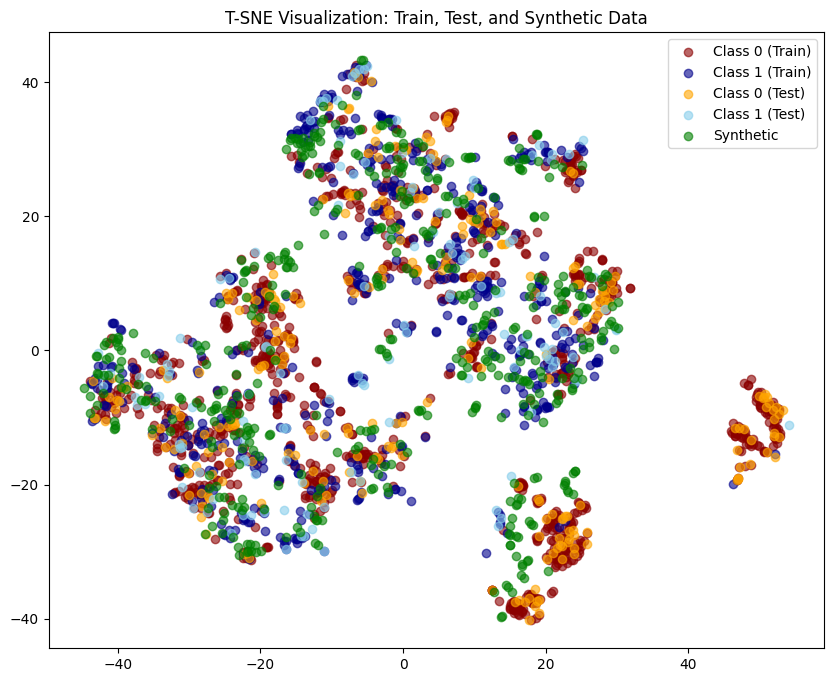

In [97]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

plt.style.use('default')  # Đảm bảo sử dụng style mặc định

# Giả sử bạn đã có:
# - X_train, y_train: Dữ liệu train và nhãn
# - X_test, y_test: Dữ liệu test và nhãn
# - X_synthetic: Dữ liệu synthetic

# 1) Gộp dữ liệu
X_plot = torch.cat([X_train, X_test, X_synthetic], dim=0).numpy()

# Tạo nhãn:
# - Phần đầu: y_train (0 hoặc 1)
# - Tiếp theo: y_test (0 hoặc 1)
# - Cuối cùng: synthetic (2)
N_train = len(X_train)
N_test = len(X_test)
N_synthetic = len(X_synthetic)
y_plot = np.concatenate([
    y_train.numpy(),            # Nhãn train
    y_test.numpy(),             # Nhãn test
    np.full((N_synthetic,), 2)  # Nhãn synthetic
], axis=0)

# 2) Chuẩn hoá dữ liệu (nếu cần)
scaler = StandardScaler()
X_plot_scaled = scaler.fit_transform(X_plot)

# 3) Tính T-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_embedded = tsne.fit_transform(X_plot_scaled)
# X_embedded.shape = (N_train + N_test + N_synthetic, 2)

# 4) Vẽ
plt.figure(figsize=(10, 8), facecolor='white')  # Đặt nền trắng

# Train Class 0 -> đỏ
idx0_train = (y_plot[:N_train] == 0)
plt.scatter(X_embedded[:N_train][idx0_train, 0], X_embedded[:N_train][idx0_train, 1],
            c='darkred', alpha=0.6, label='Class 0 (Train)')

# Train Class 1 -> xanh dương
idx1_train = (y_plot[:N_train] == 1)
plt.scatter(X_embedded[:N_train][idx1_train, 0], X_embedded[:N_train][idx1_train, 1],
            c='darkblue', alpha=0.6, label='Class 1 (Train)')

# Test Class 0 -> cam
idx0_test = (y_plot[N_train:N_train + N_test] == 0)
plt.scatter(X_embedded[N_train:N_train + N_test][idx0_test, 0], 
            X_embedded[N_train:N_train + N_test][idx0_test, 1],
            c='orange', alpha=0.6, label='Class 0 (Test)')

# Test Class 1 -> xanh nhạt
idx1_test = (y_plot[N_train:N_train + N_test] == 1)
plt.scatter(X_embedded[N_train:N_train + N_test][idx1_test, 0], 
            X_embedded[N_train:N_train + N_test][idx1_test, 1],
            c='skyblue', alpha=0.6, label='Class 1 (Test)')

# Synthetic Data -> xanh lá
idx_syn = (y_plot[N_train + N_test:] == 2)
plt.scatter(X_embedded[N_train + N_test:][idx_syn, 0], 
            X_embedded[N_train + N_test:][idx_syn, 1],
            c='green', alpha=0.6, label='Synthetic')

plt.title("T-SNE Visualization: Train, Test, and Synthetic Data")
plt.legend()
plt.show()


In [98]:
# 4.4: Train mô hình TransformerDetector
train_dataset_final = TensorDataset(X_train_final, y_train_final)
test_dataset = TensorDataset(X_test, y_test)
train_loader_final = DataLoader(train_dataset_final, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)
print("Sau khi oversampling bằng VAE:")
unique, counts = np.unique(y_train_final.numpy(), return_counts=True)
print("Phân phối lớp trong tập train:", dict(zip(unique, counts)))
model = TransformerDetector(input_size=input_dim).to(device)
optimizer_tf = Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

Sau khi oversampling bằng VAE:
Phân phối lớp trong tập train: {0.0: 1014, 1.0: 1014}


In [99]:
num_epochs_tf = 100
for epoch in range(num_epochs_tf):
    train_loss = train_detector(model, train_loader_final, optimizer_tf, criterion, device)
    print(f"[Transformer] Epoch {epoch+1}/{num_epochs_tf}, Loss={train_loss:.4f}")

    # Đánh giá
    print("Test set evaluation:")
    evaluate_with_classification_report_and_auc(model, test_loader, device, threshold=0.5)
    print("-" * 40)

[Transformer] Epoch 1/100, Loss=0.5904
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.89      0.46      0.60       254
     Class 1       0.47      0.90      0.61       135

    accuracy                           0.61       389
   macro avg       0.68      0.68      0.61       389
weighted avg       0.74      0.61      0.61       389

AUC-ROC: 0.7786
----------------------------------------
[Transformer] Epoch 2/100, Loss=0.5160
Test set evaluation:
              precision    recall  f1-score   support

     Class 0       0.78      0.81      0.80       254
     Class 1       0.62      0.57      0.59       135

    accuracy                           0.73       389
   macro avg       0.70      0.69      0.69       389
weighted avg       0.72      0.73      0.72       389

AUC-ROC: 0.7806
----------------------------------------
[Transformer] Epoch 3/100, Loss=0.4916
Test set evaluation:
              precision    recall  f1-score   suppor

KeyboardInterrupt: 